In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv


# Loading Data from Database

In [2]:
load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")


In [3]:
from urllib.parse import quote_plus

password = quote_plus(DB_PASSWORD)

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{password}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    connect_args={"sslmode": "require"},
)


# Loading Data to Panda's Dataframe

In [4]:
query = """
select *
from fct_customer_features
"""

df = pd.read_sql(query, engine)


In [5]:
df.head()


,customer_id,total_orders,total_spend,avg_order_value,recency_days,converted
0,12346.0,2,0.00,0.000000,325.0,0
1,12347.0,7,4310.00,23.681319,1.0,1
2,12348.0,4,1797.24,57.975484,74.0,0
3,12349.0,1,1757.55,24.076027,18.0,1
4,12350.0,1,334.40,19.670588,309.0,0


In [6]:
df.shape


(4372, 6)

In [7]:
df["converted"].value_counts()


converted
0    2630
1    1742
Name: count, dtype: int64

In [8]:
df.columns

Index(['customer_id', 'total_orders', 'total_spend', 'avg_order_value',
       'recency_days', 'converted'],
      dtype='object')

# Loading Model for Interpretation

In [9]:
X = df.drop(columns=["customer_id", "converted", "recency_days"])
y = df["converted"]

X.columns.tolist()


['total_orders', 'total_spend', 'avg_order_value']

In [10]:
import joblib
model = joblib.load("model.joblib")
model


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

# Features and Target relationship

In [11]:
importances = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances


total_orders       0.477267
total_spend        0.388633
avg_order_value    0.134101
dtype: float64

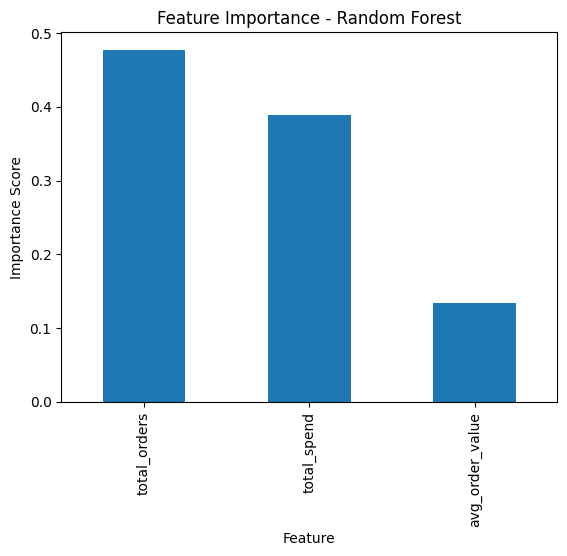

In [13]:
import matplotlib.pyplot as plt

importances.plot(kind="bar")
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.show()


### Interpretation

- `total_orders` is the most important feature, indicating that purchase frequency
  is the strongest signal for future conversion.
- `total_spend` contributes significantly, capturing long-term customer value.
- `avg_order_value` adds supporting signal but is less influential.

This aligns with business intuition: customers who buy frequently and spend more
are more likely to convert again.


### Why `customer_id` Was Excluded

- `customer_id` is a unique identifier, not a behavioral feature.
- Including it would allow the model to memorize customers.
- It provides no generalizable signal for unseen data.

For this reason, `customer_id` was excluded from training.


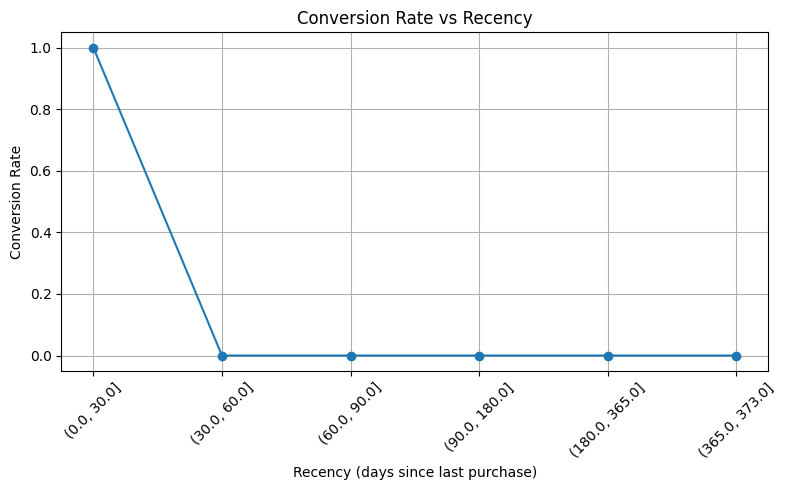

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(
    conversion_by_recency["recency_bin"].astype(str),
    conversion_by_recency["converted"],
    marker="o"
)

plt.title("Conversion Rate vs Recency")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Why `recency_days` Was Not Used as a Feature

The plots above show a near-deterministic relationship between `recency_days`
and the target variable `converted`.

Because the target was defined using `recency_days`, including it as a feature
would allow the model to trivially infer the label, resulting in perfect but
misleading performance.

For this reason, `recency_days` was intentionally excluded from model training
and used only for exploratory analysis and label definition.


### Conclusion

This notebook validates that the final model:
- Learns meaningful customer behavior patterns
- Avoids data leakage
- Is interpretable and aligned with business logic

The analysis confirms that the model’s performance is trustworthy and suitable
for real-world decision-making.
